# Common Random Numbers

Let us compare two two M/M/1 queueing systems with different service rates:
   - System 1: Service rate = 1.0
   - System 2: Service rate = 1.2 (faster)

2. We compare two methods:
   - Independent sampling: Using different random numbers for each system
   - Common Random Numbers: Using the same random numbers for both systems


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import deque

In [2]:
class QueueingSystem:
    def __init__(self, service_rate):
        self.service_rate = service_rate
        self.queue = deque()
        self.current_time = 0
        self.wait_times = []
        self.server_idle = True
        self.next_completion = float('inf')
    
    def process_arrival(self, arrival_time, service_time):
        self.current_time = arrival_time
        
        # If server is idle, start service immediately
        if self.server_idle:
            self.next_completion = self.current_time + service_time
            self.server_idle = False
            self.wait_times.append(0)
        else:
            # Add to queue
            self.queue.append((arrival_time, service_time))
    
    def process_completion(self):
        self.current_time = self.next_completion
        
        if self.queue:
            # Get next customer from queue
            arrival_time, service_time = self.queue.popleft()
            wait_time = self.current_time - arrival_time
            self.wait_times.append(wait_time)
            
            # Schedule next completion
            self.next_completion = self.current_time + service_time
        else:
            self.server_idle = True
            self.next_completion = float('inf')

Variance reduction achieved by CRN: 100.0%
Standard error reduction: 100.0%


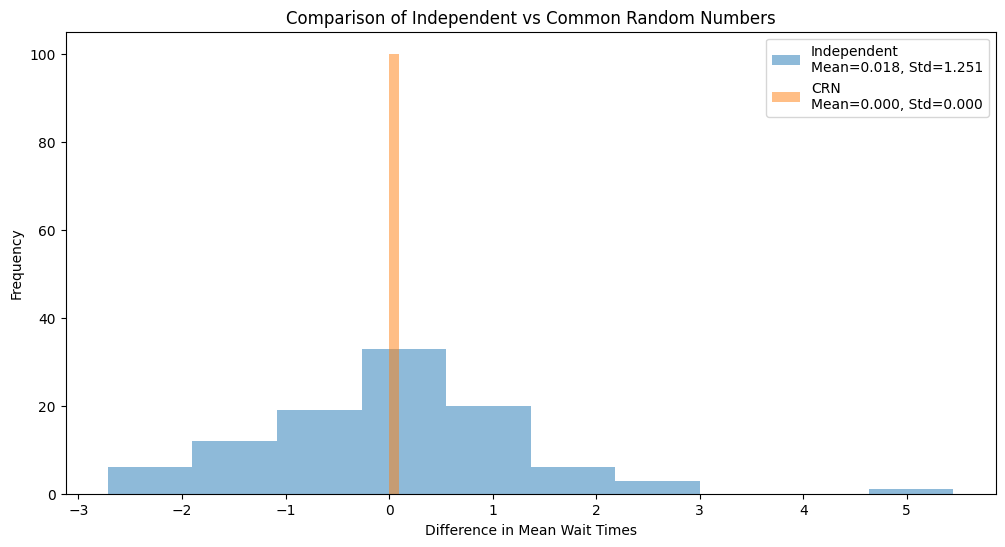

In [3]:
def run_simulation(arrivals, service_times, service_rate):
    system = QueueingSystem(service_rate)
    completion_times = []
    
    i = 0
    while i < len(arrivals) or not system.server_idle:
        # Process next arrival or completion, whichever comes first
        if i < len(arrivals) and arrivals[i] < system.next_completion:
            system.process_arrival(arrivals[i], service_times[i])
            i += 1
        else:
            completion_times.append(system.next_completion)
            system.process_completion()
    
    return np.mean(system.wait_times)

def compare_systems_independent(num_customers, num_replications):
    differences = []
    
    for _ in range(num_replications):
        # Generate different random numbers for each system
        arrivals1 = np.cumsum(np.random.exponential(1, num_customers))
        service_times1 = np.random.exponential(0.8, num_customers)
        
        arrivals2 = np.cumsum(np.random.exponential(1, num_customers))
        service_times2 = np.random.exponential(0.8, num_customers)
        
        mean_wait1 = run_simulation(arrivals1, service_times1, 1.0)
        mean_wait2 = run_simulation(arrivals2, service_times2, 1.2)
        
        differences.append(mean_wait1 - mean_wait2)
    
    return differences

def compare_systems_crn(num_customers, num_replications):
    differences = []
    
    for _ in range(num_replications):
        # Use same random numbers for both systems
        arrivals = np.cumsum(np.random.exponential(1, num_customers))
        service_times = np.random.exponential(0.8, num_customers)
        
        mean_wait1 = run_simulation(arrivals.copy(), service_times.copy(), 1.0)
        mean_wait2 = run_simulation(arrivals.copy(), service_times.copy(), 1.2)
        
        differences.append(mean_wait1 - mean_wait2)
    
    return differences

# Run simulations
num_customers = 1000
num_replications = 100

independent_differences = compare_systems_independent(num_customers, num_replications)
crn_differences = compare_systems_crn(num_customers, num_replications)

# Calculate statistics
ind_mean = np.mean(independent_differences)
ind_std = np.std(independent_differences)
crn_mean = np.mean(crn_differences)
crn_std = np.std(crn_differences)

# Plot results
plt.figure(figsize=(12, 6))
plt.hist(independent_differences, alpha=0.5, label=f'Independent\nMean={ind_mean:.3f}, Std={ind_std:.3f}')
plt.hist(crn_differences, alpha=0.5, label=f'CRN\nMean={crn_mean:.3f}, Std={crn_std:.3f}')
plt.xlabel('Difference in Mean Wait Times')
plt.ylabel('Frequency')
plt.title('Comparison of Independent vs Common Random Numbers')
plt.legend()

# Calculate and print variance reduction
variance_reduction = (np.var(independent_differences) - np.var(crn_differences)) / np.var(independent_differences) * 100

print(f"Variance reduction achieved by CRN: {variance_reduction:.1f}%")
print(f"Standard error reduction: {(1 - crn_std/ind_std) * 100:.1f}%")

## Backfire!

CRN can actually increase variance in some situations. Let us consider two competing stores:

1. A luxury store that does better in good weather (higher temperatures)
2. A budget store that does better in bad weather (lower temperatures)

Key points of this corrected example:

1. Why CRN backfires here:
   - The stores respond oppositely to the same weather conditions
   - When it's warm, the luxury store does well but the budget store suffers
   - When it's cold, the budget store does well but the luxury store suffers
   - This creates a negative correlation between the systems when using CRN

2. Mathematical explanation:
   - Variance of a difference: Var(A-B) = Var(A) + Var(B) - 2Cov(A,B)
   - CRN creates a negative covariance between systems
   - A negative covariance increases the variance of the difference


Variance increase due to CRN: 82.0%
Standard error increase: 34.9%
F-test p-value: 0.0000
Correlation between systems: -0.8121


Text(0.5, 1.0, 'Negative Correlation Between Systems\nShowing Why CRN Backfires')

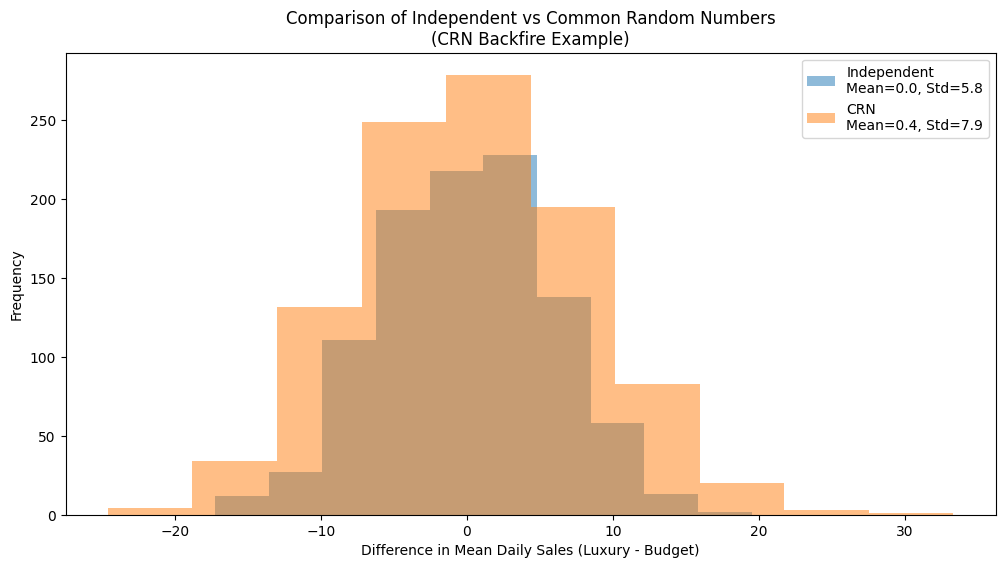

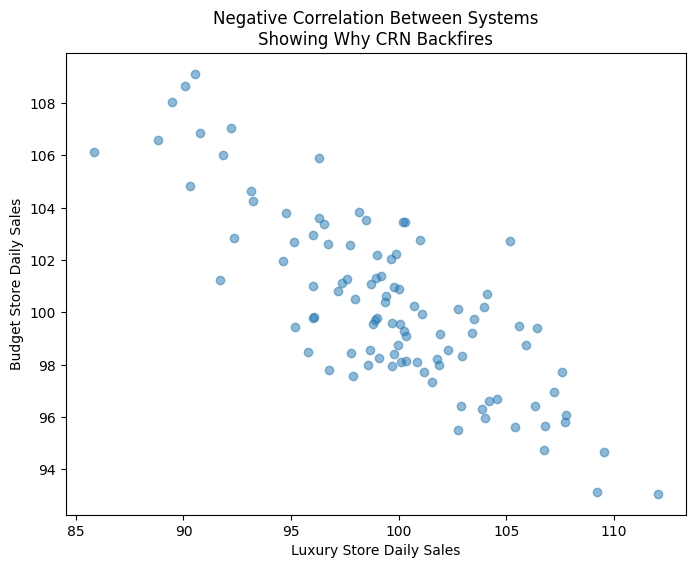

In [5]:
class CompetingStores:
    def __init__(self, is_luxury):
        self.is_luxury = is_luxury
        self.daily_sales = []
    
    def simulate_day(self, weather_temp):
        # Luxury store does better in good weather (high temp)
        # Budget store does better in bad weather (low temp)
        if self.is_luxury:
            # Luxury store: more sales in good weather
            sales = 100 + 5 * (weather_temp - 15) + np.random.normal(0, 10)
        else:
            # Budget store: more sales in bad weather
            sales = 100 - 3 * (weather_temp - 15) + np.random.normal(0, 10)
        
        self.daily_sales.append(max(0, sales))
        return self.daily_sales[-1]

def run_simulation_store(is_luxury, temperatures, noise, simulation_days):
    store = CompetingStores(is_luxury)
    total_sales = 0
    
    for day in range(simulation_days):
        temp = temperatures[day]
        total_sales += store.simulate_day(temp)
    
    return total_sales / simulation_days

def compare_systems(simulation_days, num_replications, use_crn=True):
    differences = []
    
    for _ in range(num_replications):
        if use_crn:
            # Common Random Numbers for weather
            temperatures = np.random.normal(15, 5, simulation_days)  # mean 15°C, std 5°C
            noise = np.random.normal(0, 10, simulation_days)
            
            # Luxury store
            result1 = run_simulation_store(True, temperatures, noise, simulation_days)
            
            # Budget store
            result2 = run_simulation_store(False, temperatures, noise, simulation_days)
        else:
            # Independent Random Numbers
            temperatures1 = np.random.normal(15, 5, simulation_days)
            temperatures2 = np.random.normal(15, 5, simulation_days)
            noise1 = np.random.normal(0, 10, simulation_days)
            noise2 = np.random.normal(0, 10, simulation_days)
            
            # Luxury store
            result1 = run_simulation_store(True, temperatures1, noise1, simulation_days)
            
            # Budget store
            result2 = run_simulation_store(False, temperatures2, noise2, simulation_days)
        
        differences.append(result1 - result2)
    
    return differences

# Run simulations
simulation_days = 30
num_replications = 1000

# Run both independent and CRN simulations
ind_differences = compare_systems(simulation_days, num_replications, use_crn=False)
crn_differences = compare_systems(simulation_days, num_replications, use_crn=True)

# Calculate statistics
ind_mean = np.mean(ind_differences)
ind_std = np.std(ind_differences)
crn_mean = np.mean(crn_differences)
crn_std = np.std(crn_differences)

# Perform F-test for variance comparison
f_statistic = np.var(crn_differences) / np.var(ind_differences)
dof = num_replications - 1
f_p_value = 2 * min(stats.f.cdf(f_statistic, dof, dof),
                    1 - stats.f.cdf(f_statistic, dof, dof))

# Plot results
plt.figure(figsize=(12, 6))
plt.hist(ind_differences, alpha=0.5, label=f'Independent\nMean={ind_mean:.1f}, Std={ind_std:.1f}')
plt.hist(crn_differences, alpha=0.5, label=f'CRN\nMean={crn_mean:.1f}, Std={crn_std:.1f}')
plt.xlabel('Difference in Mean Daily Sales (Luxury - Budget)')
plt.ylabel('Frequency')
plt.title('Comparison of Independent vs Common Random Numbers\n(CRN Backfire Example)')
plt.legend()

# Calculate and print variance increase
variance_increase = (np.var(crn_differences) - np.var(ind_differences)) / np.var(ind_differences) * 100

print(f"Variance increase due to CRN: {variance_increase:.1f}%")
print(f"Standard error increase: {(crn_std/ind_std - 1) * 100:.1f}%")
print(f"F-test p-value: {f_p_value:.4f}")

# Demonstrating the negative correlation
def calculate_correlation(simulation_days, num_samples):
    luxury_results = []
    budget_results = []
    
    for _ in range(num_samples):
        temperatures = np.random.normal(15, 5, simulation_days)
        noise = np.random.normal(0, 10, simulation_days)
        
        luxury_result = run_simulation_store(True, temperatures, noise, simulation_days)
        budget_result = run_simulation_store(False, temperatures, noise, simulation_days)
        
        luxury_results.append(luxury_result)
        budget_results.append(budget_result)
    
    correlation = np.corrcoef(luxury_results, budget_results)[0, 1]
    return correlation, luxury_results, budget_results

correlation, luxury_results, budget_results = calculate_correlation(simulation_days, 100)
print(f"Correlation between systems: {correlation:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(luxury_results, budget_results, alpha=0.5)
plt.xlabel('Luxury Store Daily Sales')
plt.ylabel('Budget Store Daily Sales')
plt.title('Negative Correlation Between Systems\nShowing Why CRN Backfires')

# Antithetic Variates

Let us consider an M/M/1 queue:
   
2. Key concepts demonstrated:
   - Generation of antithetic variates
   - Comparison of regular vs. antithetic sampling
   - Visualization of variance reduction
   - Statistical analysis of the results

3. How antithetic sampling works here:
   - For regular random numbers U, we use both U and (1-U)
   - This creates negative correlation between samples
   - When averaged, this negative correlation reduces variance

4. The code includes:
   - A `QueueSystem` class that simulates the queue
   - Functions to generate antithetic samples
   - Comparative simulation using both regular and antithetic sampling
   - Statistical analysis and visualization

When you run this code, you should see:
1. Lower variance in the antithetic sampling results
2. A negative correlation between antithetic pairs
3. Statistical confirmation of variance reduction

Why antithetic sampling works:
1. Var((X + Y)/2) = (Var(X) + Var(Y) + 2Cov(X,Y))/4
2. Antithetic sampling creates negative correlation (negative covariance)
3. This negative covariance reduces the overall variance of the estimate
 

Variance reduction achieved by antithetic sampling: 65.2%
Standard error reduction: 41.0%
F-test p-value: 0.0000


Text(0.5, 1.0, 'Correlation Between Antithetic Pairs\nCorrelation = -0.195')

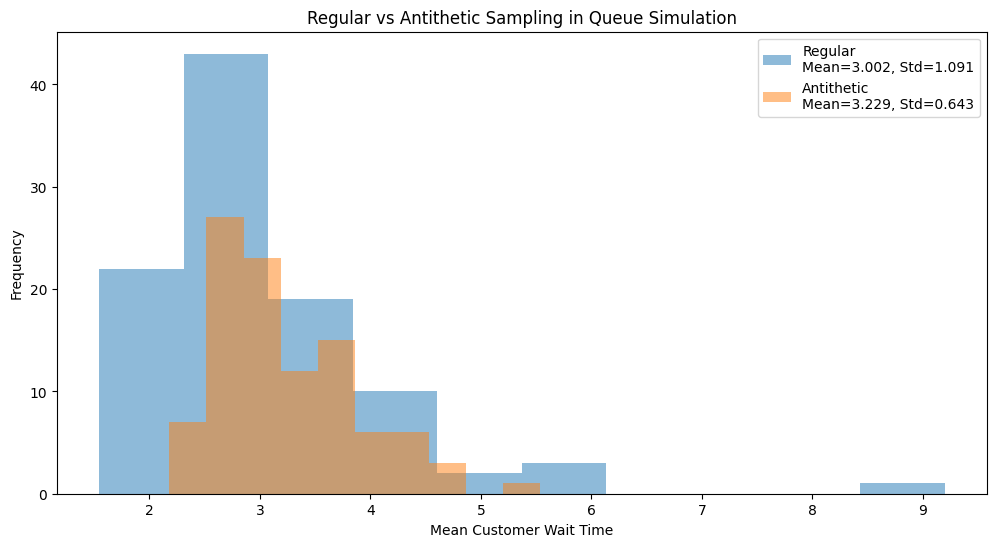

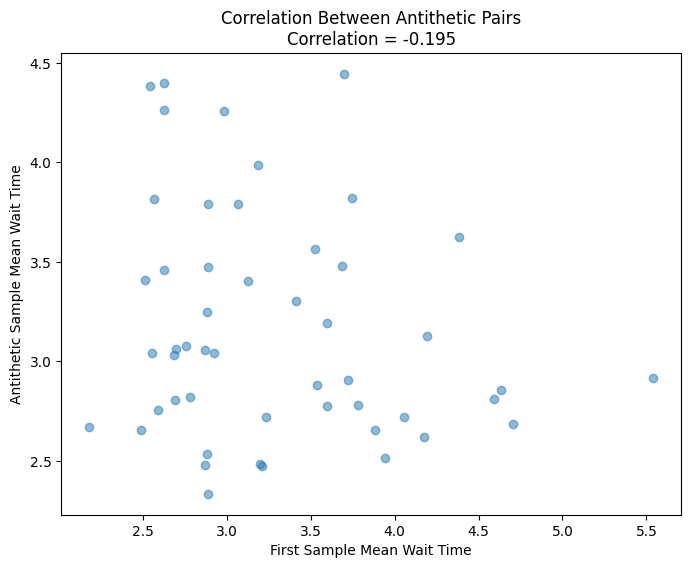

In [6]:
def generate_antithetic_samples(mean, size):
    u = np.random.random(size)
    sample1 = -mean * np.log(u)        # Regular exponential samples
    sample2 = -mean * np.log(1 - u)    # Antithetic samples
    return sample1, sample2

def simulate_regular_vs_antithetic(num_customers, num_replications):
    regular_means = []
    antithetic_means = []
    
    arrival_mean = 1.0    # Mean time between arrivals
    service_mean = 0.8    # Mean service time
    service_rate = 1/service_mean
    
    for rep in range(num_replications):
        # Regular sampling
        reg_arrivals = np.cumsum(np.random.exponential(arrival_mean, num_customers))
        reg_service_times = np.random.exponential(service_mean, num_customers)
        regular_result = run_simulation(reg_arrivals, reg_service_times, service_rate)
        regular_means.append(regular_result)
        
        # Antithetic sampling
        arrivals1, arrivals2 = generate_antithetic_samples(arrival_mean, num_customers)
        service1, service2 = generate_antithetic_samples(service_mean, num_customers)
        
        # Run simulation with first sample
        ant_arrivals1 = np.cumsum(arrivals1)
        result1 = run_simulation(ant_arrivals1, service1, service_rate)
        
        # Run simulation with antithetic sample
        ant_arrivals2 = np.cumsum(arrivals2)
        result2 = run_simulation(ant_arrivals2, service2, service_rate)
        
        # Average the results
        antithetic_means.append((result1 + result2) / 2)
    
    return regular_means, antithetic_means

# Run simulations
num_customers = 1000
num_replications = 100

regular_results, antithetic_results = simulate_regular_vs_antithetic(num_customers, num_replications)

# Calculate statistics
reg_mean, reg_std = np.mean(regular_results), np.std(regular_results)
ant_mean, ant_std = np.mean(antithetic_results), np.std(antithetic_results)

# Perform F-test for variance comparison
f_statistic = np.var(regular_results) / np.var(antithetic_results)
dof = num_replications - 1
f_p_value = 2 * min(stats.f.cdf(f_statistic, dof, dof),
                    1 - stats.f.cdf(f_statistic, dof, dof))

# Plot results
plt.figure(figsize=(12, 6))
plt.hist(regular_results, alpha=0.5, label=f'Regular\nMean={reg_mean:.3f}, Std={reg_std:.3f}')
plt.hist(antithetic_results, alpha=0.5, label=f'Antithetic\nMean={ant_mean:.3f}, Std={ant_std:.3f}')
plt.xlabel('Mean Customer Wait Time')
plt.ylabel('Frequency')
plt.title('Regular vs Antithetic Sampling in Queue Simulation')
plt.legend()

# Calculate and print variance reduction
variance_reduction = (1 - np.var(antithetic_results)/np.var(regular_results)) * 100
print(f"Variance reduction achieved by antithetic sampling: {variance_reduction:.1f}%")
print(f"Standard error reduction: {(1 - ant_std/reg_std) * 100:.1f}%")
print(f"F-test p-value: {f_p_value:.4f}")

# Demonstrating the negative correlation between antithetic pairs
plt.figure(figsize=(8, 6))
antithetic_pairs = np.array(antithetic_results).reshape(-1, 2)
correlation = np.corrcoef(antithetic_pairs[:, 0], antithetic_pairs[:, 1])[0, 1]
plt.scatter(antithetic_pairs[:, 0], antithetic_pairs[:, 1], alpha=0.5)
plt.xlabel('First Sample Mean Wait Time')
plt.ylabel('Antithetic Sample Mean Wait Time')
plt.title(f'Correlation Between Antithetic Pairs\nCorrelation = {correlation:.3f}')
plt.show()

N.B.: also antithetic sampling can backfire